# Predicting Heart Disease

In this project, we will use the [Kaggle data](https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction) and build a K-Nearest Neighbors classifier to accurately predict the likelihood of a patient having a heart disease. 

In [343]:
# import libraries
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier, KNeighborsTransformer
from sklearn.pipeline import Pipeline

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
#set seaborn theme
#sns.set_style("darkgrid", {'grid.color': 'gray'})
plt.style.use("dark_background")
#set the grid color to gray
plt.rcParams['grid.color'] = "gray"
#set the outline of the plot to gray
plt.rcParams['axes.edgecolor'] = "gray"
sns.set_palette("muted")


## EDA: Descriptive Statistics
We will start by exploring our dataset. Each patient has the following information:

1. `Age`: Age [years]
2. `Sex`: Sex [M: Male, F: Female]
3. `ChestPainType`: Chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
4. `RestingBP`: Resting blood pressure [mm Hg]
5. `Cholesterol`: Serum cholesterol [mm/dl]
6. `FastingBS`: Fasting blood sugar [1: > 120 mg/dl, 0: otherwise]
7. `RestingECG`: Resting electrocardiogram results [Normal, ST, LVH]
8. `MaxHR`: Maximum heart rate achieved [60-202]
9. `ExerciseAngina`: Exercise-induced angina [Y: Yes, N: No]
10. `Oldpeak`: ST depression [Numeric]
11. `ST_Slope`: Slope of peak exercise ST segment [Up, Flat, Down]
12. `HeartDisease`: Output class [1: heart disease, 0: Normal]


In [344]:
#load dataset
df = pd.read_csv("heart_disease_prediction.csv")

In [345]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


The dataset seems to contain both numerical and categorical features. Let's look at the datatype for each column.

In [346]:
print(df.dtypes)
df.dtypes.value_counts()

Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object


int64      6
object     5
float64    1
Name: count, dtype: int64

`7` features in total are numerical while `5` are categorical. However, two of the numerical features, `FastingBS` and `HeartDisease` are categorical as well. 

We will focus on the numerical variables first.

In [347]:
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


From the table above, we can observe that:
- Average patient age: ~53 years.
- Median `Cholesterol` is ~25 mm/dl higher than the mean, indicating a left-skewed distribution with possible outliers.
- `RestingBP` and `Cholesterol` have unrealistic minimum values of zero.
- No apparent missing values, but we will confirm this.

Next, we will clean `RestingBP` and `Cholesterol` values and examine categorical variables and their relationship with `HeartDisease`.


In [348]:
df.isna().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

There are no missing values in this dataset!

## EDA: Categorical Data

We identified that most of the categorical columns are all of dtype **object**.

In [349]:
df.describe(include=['object'])

,Sex,ChestPainType,RestingECG,ExerciseAngina,ST_Slope
count,918,918,918,918,918
unique,2,4,3,2,3
top,M,ASY,Normal,N,Flat
freq,725,496,552,547,460


We can confirm that those columns are indeed categorical given the number of unique values in each of them. But, we can't gather much else. Also, `FastingBS` and `HeartDisease` are categorical as well since they only contain binary values. We can confirm that quickly as well.

In [350]:
df["FastingBS"].unique(), df["HeartDisease"].unique() 

(array([0, 1], dtype=int64), array([0, 1], dtype=int64))

Let's start looking at the categories in more detail.

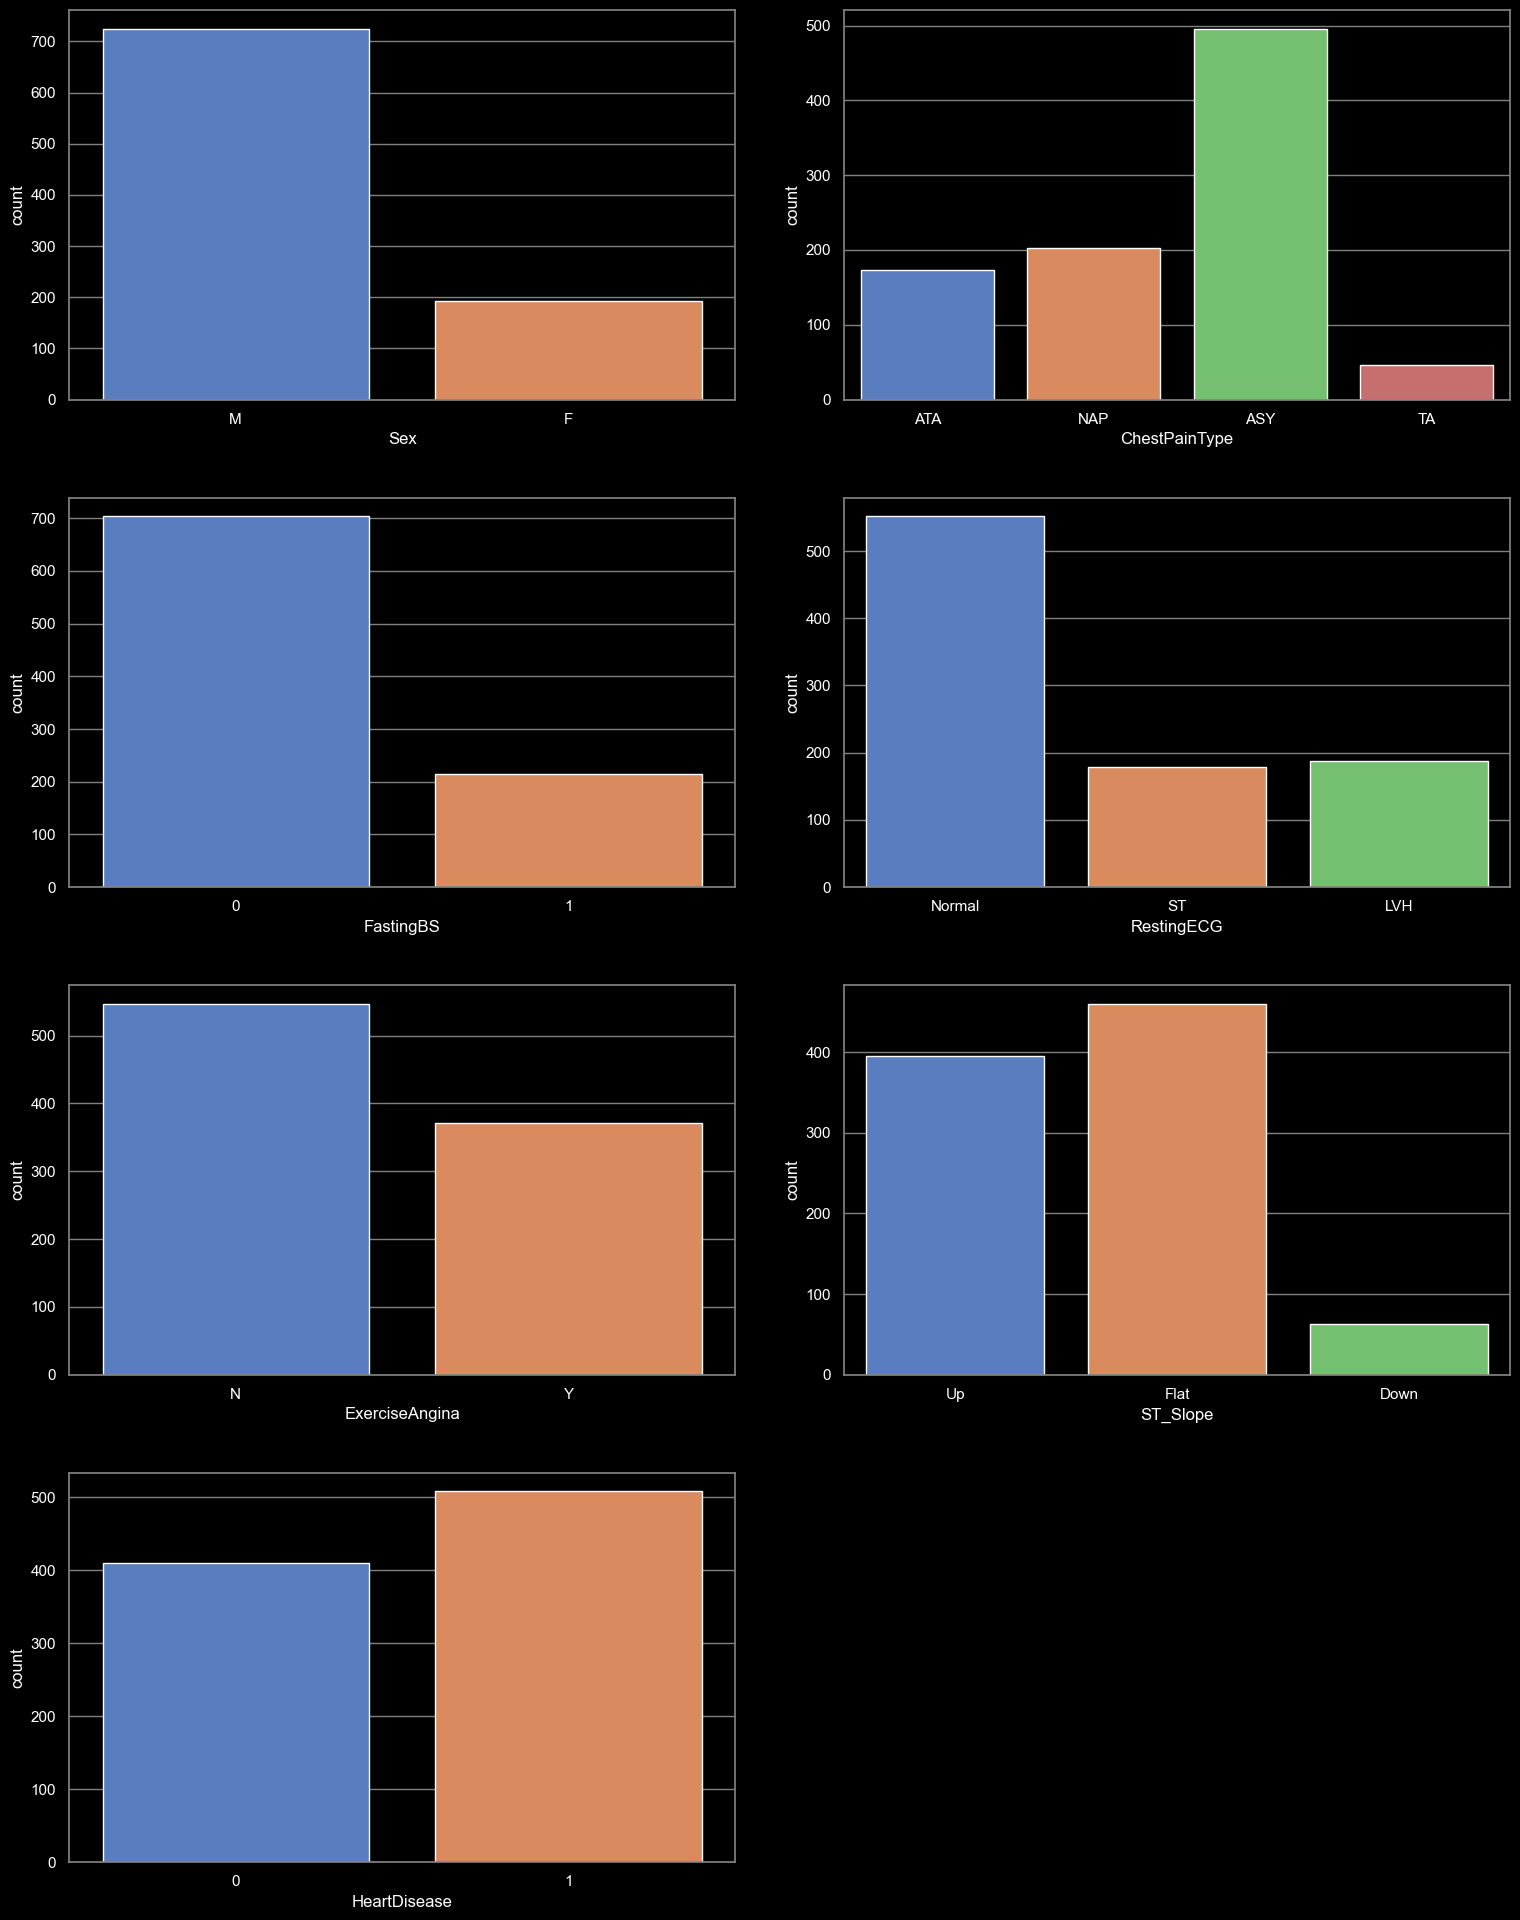

In [351]:
categorical_cols = ["Sex", "ChestPainType", "FastingBS", "RestingECG", "ExerciseAngina", "ST_Slope", "HeartDisease"]

fig = plt.figure(figsize=(16,20))

for idx, col in enumerate(categorical_cols, start=1):
    ax = plt.subplot(4, 2, idx)
    sns.countplot(x=df[col], ax=ax, hue= df[col])
    #hide legends if they exist
    legend = ax.get_legend()
    if legend:
        legend.remove()
    fig.tight_layout(pad=3.0)


    

- The dataset is highly skewed towards male patients. There are `725` male patients and `193` female patients. This could potentially induce a bias in our model.
- `496` patients had asymptomatic (ASY) chest pain.
- `552` patients had a normal resting ECG.
- `704` patients had blood sugar lower than 120 mg/dl.

Grouping by `HeartDisease` will clarify the data distribution.

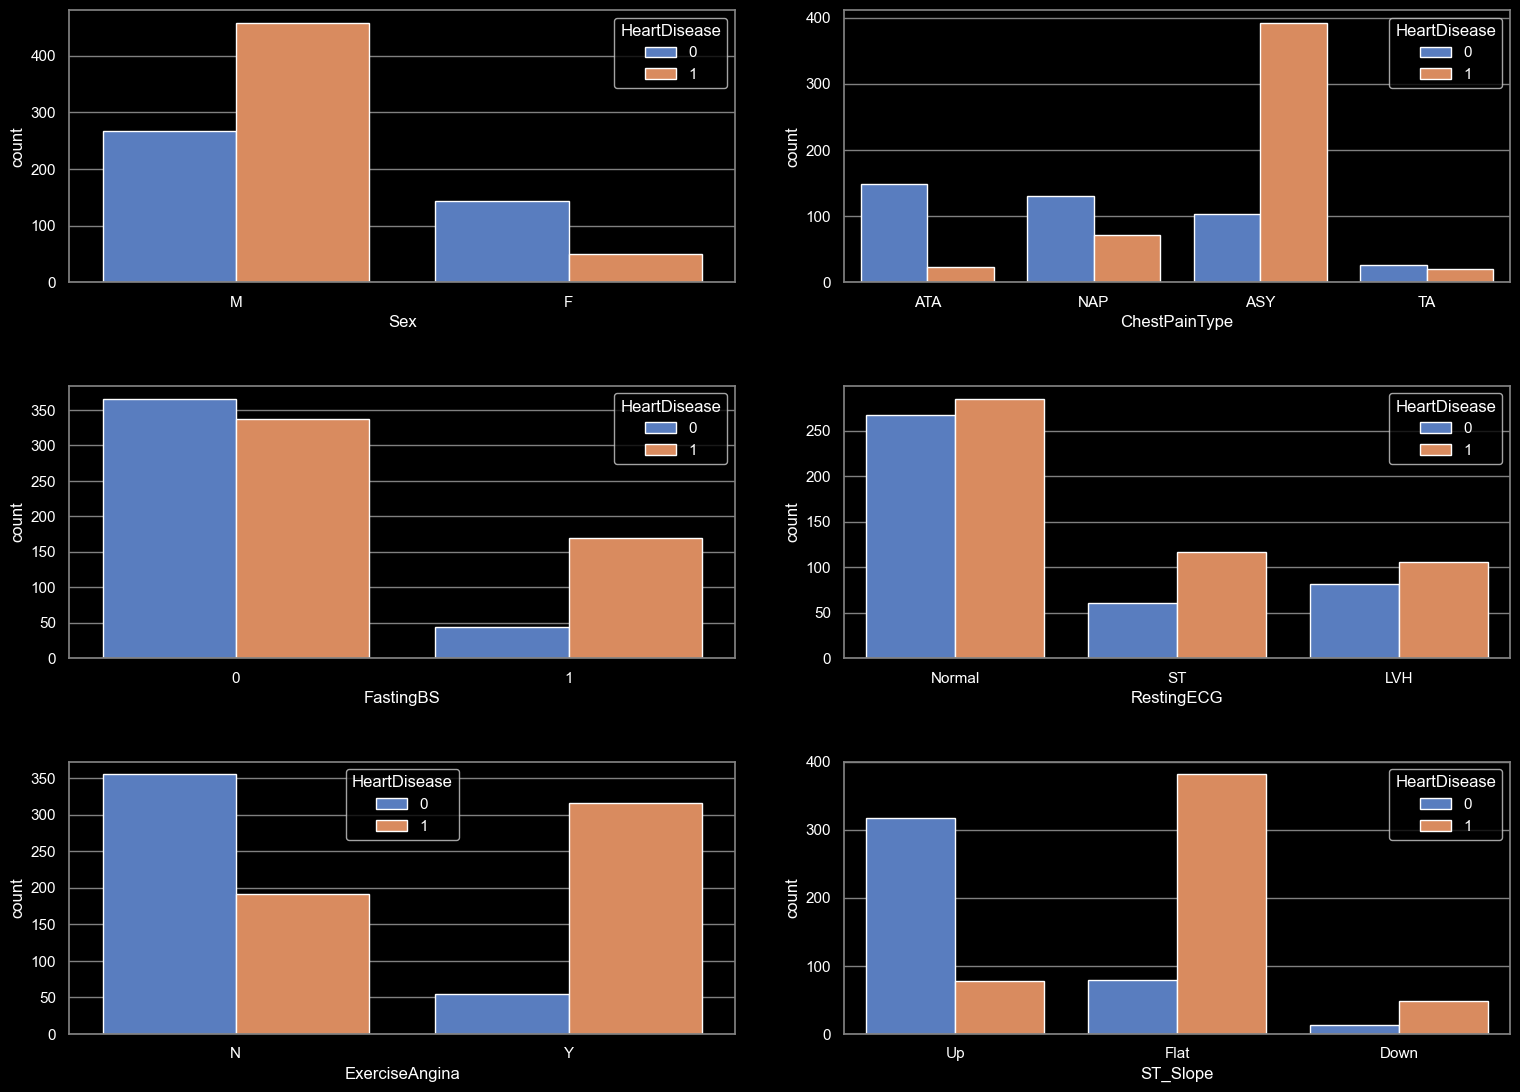

In [352]:
fig = plt.figure(figsize=(16,15))

for idx, col in enumerate(categorical_cols[:-1]):
    ax = plt.subplot(4, 2, idx+1)
    # group by HeartDisease
    sns.countplot(x=df[col], hue=df["HeartDisease"], ax=ax)
    # add data labels to each bar
    fig.tight_layout(pad=3.0)

- We can further notice how skewed the dataset is towards male patients. Only `50` female patients in the dataset have been diagnosed with heart disease.
- `392` patients with heart disease had asymptomatic (ASY) chest pain, indicating chest pain might not be a reliable feature.
- `170` patients with blood sugar > 120 mg/dl were diagnosed with heart disease.
- `316` patients with exercise-induced angina were diagnosed with heart disease.
- `381` patients with a flat ST slope were diagnosed with heart disease.

We will clean the dataset before selecting relevant features.

## Data Cleaning

We identified that there are no missing values. However, as we noticed earlier, a couple of columns have 0 values which don't make sense.

We will look at how many zero values `RestingBP` and `Cholesterol` contain and decide how to handle those.

In [353]:
df[df["RestingBP"] == 0]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
449,55,M,NAP,0,0,0,Normal,155,N,1.5,Flat,1


In [354]:
df[df["Cholesterol"] == 0]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
293,65,M,ASY,115,0,0,Normal,93,Y,0.0,Flat,1
294,32,M,TA,95,0,1,Normal,127,N,0.7,Up,1
295,61,M,ASY,105,0,1,Normal,110,Y,1.5,Up,1
296,50,M,ASY,145,0,1,Normal,139,Y,0.7,Flat,1
297,57,M,ASY,110,0,1,ST,131,Y,1.4,Up,1
...,...,...,...,...,...,...,...,...,...,...,...,...
514,43,M,ASY,122,0,0,Normal,120,N,0.5,Up,1
515,63,M,NAP,130,0,1,ST,160,N,3.0,Flat,0
518,48,M,NAP,102,0,1,ST,110,Y,1.0,Down,1
535,56,M,ASY,130,0,0,LVH,122,Y,1.0,Flat,1


`RestingBP` has only one zero value. We can remove that row from consideration. There are `172` (a large number) zero values for `Cholesterol`. So, the 0 values in `Cholesterol` for patients who were diagnosed with a heart disease will be replaced by the median of the non-zero values for patients who were diagnosed with a heart disase. And we'll do the same for those who were not diagnosed with a heart disease.

In [355]:
df_clean = df.copy()

# only keep non-zero values for RestingBP
df_clean = df_clean[df_clean["RestingBP"] != 0]

#Create mask for Cholestorol and replace accordingly
heartdisease_mask = df_clean["HeartDisease"]==0

cholesterol_without_heartdisease = df_clean[heartdisease_mask]["Cholesterol"]
cholesterol_with_heartdisease = df_clean[~heartdisease_mask]["Cholesterol"]

df_clean.loc[heartdisease_mask, "Cholesterol"] = cholesterol_without_heartdisease.replace( 0, cholesterol_without_heartdisease.median())
df_clean.loc[~heartdisease_mask, "Cholesterol"] = cholesterol_with_heartdisease.replace(0, cholesterol_with_heartdisease.median())

In [356]:
df_clean[["Cholesterol", "RestingBP"]].describe()

,Cholesterol,RestingBP
count,917.000000,917.000000
mean,239.700109,132.540894
std,54.352727,17.999749
min,85.000000,80.000000
25%,214.000000,120.000000
50%,225.000000,130.000000
75%,267.000000,140.000000
max,603.000000,200.000000


The minimum values for both have changed! There are no more zero values in either of those.

## Feature Selection

Thanks to our EDA and a general understanding of the features, we can identify some of the features that we could start with:

- `Age`
- `Sex`
- `ChestPainType`
- `Cholesterol`
- `FastingBS`


We will also identify how stronly the feature columns are correlated to the target colummn. That should help us narrow down on the features.

In order to do that, we will first convert our categorical columns into dummy variables.

In [357]:
df_clean = pd.get_dummies(df_clean, drop_first=True)
df_clean.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0.0,0,True,True,False,False,True,False,False,False,True
1,49,160,180,0,156,1.0,1,False,False,True,False,True,False,False,True,False
2,37,130,283,0,98,0.0,0,True,True,False,False,False,True,False,False,True
3,48,138,214,0,108,1.5,1,False,False,False,False,True,False,True,True,False
4,54,150,195,0,122,0.0,0,True,False,True,False,True,False,False,False,True


Now, we can find how they are correlated.

<Axes: >

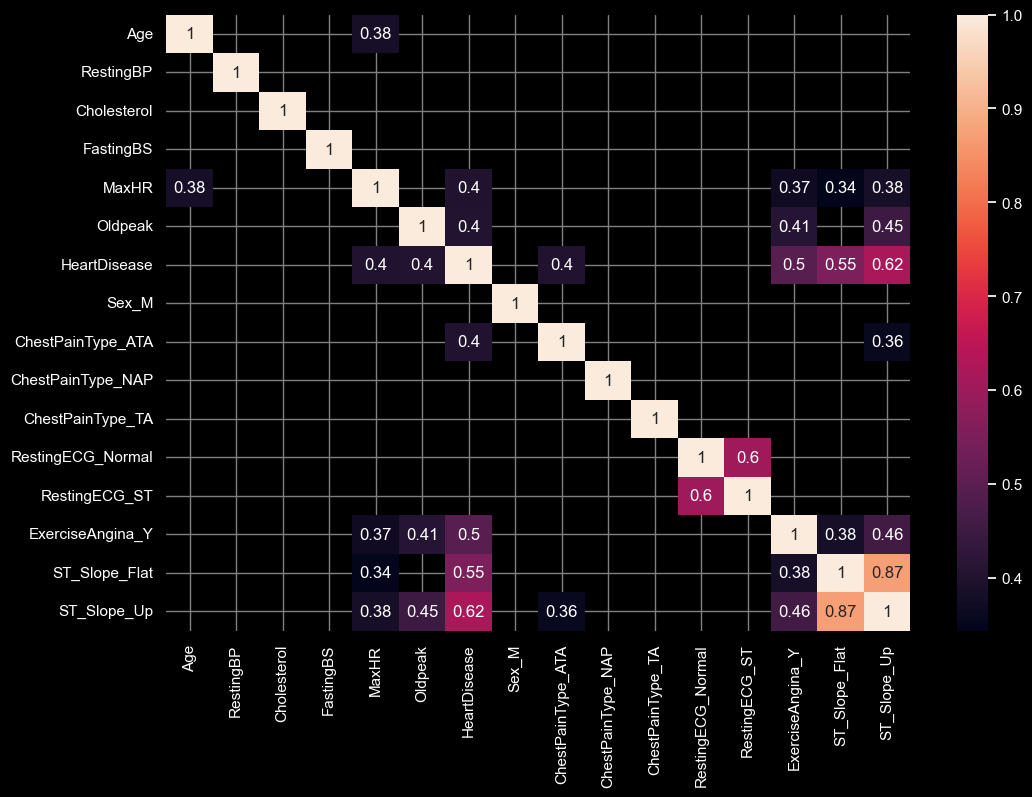

In [358]:
correlations = abs(df_clean.corr())
plt.figure(figsize=(12,8))
sns.heatmap(correlations, annot=True, mask = correlations < 0.31)

From our correlation heatmap, we can identify the following features to be positively correlated (correlation coefficient greater than 0.3) to `HeartDisease`:
- `Oldpeak`
- `MaxHR`
- `ChestPainType_ATA`
- `ExerciseAngina_Y`
- `ST_Slope_Flat`
- `ST_Slope_Up`

Let's build our model using these features!


## Building a Classifier with One Feature (Sanity Check)

We will split our dataset into a training and a test set first.

In [359]:
X = df_clean.drop(["HeartDisease"], axis=1)
y = df_clean["HeartDisease"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state = 417)

features = [
    "Oldpeak",
    "MaxHR",
    "Sex_M",
    "ExerciseAngina_Y",
    "ST_Slope_Flat",
    "ST_Slope_Up"
]

We will start with creating a model for each of the features above and evaluate their performance using accuracy as a metric.

In [360]:
for feature in features:
    knn = KNeighborsClassifier(n_neighbors = 3)
    knn.fit(X_train[[feature]], y_train)
    accuracy = knn.score(X_val[[feature]], y_val)
    print(f"The k-NN classifier trained on {feature} and with k = 3 has an accuracy of {accuracy*100:.2f}%")

The k-NN classifier trained on Oldpeak and with k = 3 has an accuracy of 58.70%
The k-NN classifier trained on MaxHR and with k = 3 has an accuracy of 55.07%
The k-NN classifier trained on Sex_M and with k = 3 has an accuracy of 61.59%
The k-NN classifier trained on ExerciseAngina_Y and with k = 3 has an accuracy of 73.19%
The k-NN classifier trained on ST_Slope_Flat and with k = 3 has an accuracy of 81.88%
The k-NN classifier trained on ST_Slope_Up and with k = 3 has an accuracy of 55.07%


Our best forming model, with an accuracy of ~`82%`, was trained on the `ST_Slope_Flat` feature with `ExerciseAngina_Y` being a close second. These make sense given the data distributions we saw previously.

We will train a model using all of these features next.

## Building a Classifier with Multiple Features

Before training on all of the above features, we need to normalize the data first. We will use scikit-learn's MinMaxScaler to scale the values between 0 and 1, and then train the model again.

In [361]:
knn_pipe = Pipeline([
    ('scaler', MinMaxScaler()),
    ('knn', KNeighborsClassifier())
])
accuracy = knn_pipe.set_params(knn__n_neighbors=3) \
                   .fit(X_train[features], y_train) \
                   .score(X_val[features], y_val)
print(f"Accuracy: {accuracy*100:.2f}")

Accuracy: 83.33


The model's accuracy jumped to ~`83%`! That's not a significant improvement, but still a good start. Using all these features results in an improved model, but, let's see what parameters/hyperparameters might be optimal.

## Hyperparameter Optimization

Let's prepare our data first. We stratify based on sex, because one of them is overrepresented

In [362]:
X = df_clean.drop(["HeartDisease"], axis=1)
y = df_clean["HeartDisease"]

features = [
    "Oldpeak",
    "Sex_M",
    "MaxHR",
    "ExerciseAngina_Y",
    "ST_Slope_Flat",
    "ST_Slope_Up"
]

X_train, X_test, y_train, y_test = train_test_split(X[features], y, test_size=0.15, random_state=417, stratify=X['Sex_M'])



# scaler = MinMaxScaler()
# X_train_scaled = scaler.fit_transform(X_train[features])

We will use grid search to explore the following range of values for a couple of hyperparameters:

- For `k` (`n_neighbors` in scikit-learn) we will use values in the range of 1 to 20.
- We will use two distance metrics - `euclidean` and `manhattan`.

In [363]:
grid_params = {"knn__n_neighbors": range(1, 20),
                "knn__metric": ["euclidean", "manhattan"]
              }

knn = KNeighborsClassifier()
knn_grid = GridSearchCV(knn_pipe, grid_params, scoring='accuracy', n_jobs=-1)
knn_grid.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('knn',
                                        KNeighborsClassifier(n_neighbors=3))]),
             n_jobs=-1,
             param_grid={'knn__metric': ['euclidean', 'manhattan'],
                         'knn__n_neighbors': range(1, 20)},
             scoring='accuracy')

In [364]:
knn_grid.best_score_*100, knn_grid.best_params_

(83.94871794871796, {'knn__metric': 'manhattan', 'knn__n_neighbors': 19})

Our best model had an accuracy of ~`84%` with `18` `n_neighbors` and `manhattan` as the distance metric. 

The accuracy of this model is only slightly better. Since `GridSearchCV` employs a cross-validation approach, it is reasonable to assume that this is a better estimate of how the model performs compared to our prior attempt.

We will evaluate our model on our test set now.

## Model Evaluation on Test Set

We need to first normalize our test set similar to how we scaled our training set.

In [365]:
accuracy = knn_grid.best_estimator_.score(X_test, y_test)
print(f" Model Accuracy on test set: {accuracy*100:.2f}")

 Model Accuracy on test set: 87.68


Our model got an accuracy of ~`88`%. That's really good! This means that our model is likely to correctly predict whether a patient is at risk for a heart disease ~`88`% of the time.

However, the accuracy being higher than the one before raises some flags.

One explanation that could explain is to look at how the data is distributed. 

In [366]:
print("Distribution of patients by their sex in the entire dataset")
print(X['Sex_M'].value_counts())

print("\nDistribution of patients by their sex in the training dataset")
print(X_train['Sex_M'].value_counts())

print("\nDistribution of patients by their sex in the test dataset")
print(X_test['Sex_M'].value_counts())

Distribution of patients by their sex in the entire dataset
Sex_M
True     724
False    193
Name: count, dtype: int64

Distribution of patients by their sex in the training dataset
Sex_M
True     615
False    164
Name: count, dtype: int64

Distribution of patients by their sex in the test dataset
Sex_M
True     109
False     29
Name: count, dtype: int64


We used `Sex` as one of our features for training the model.

- `X` had `724` males and `193` females.
- `X_train` had `615` males and `164` females.
- `X_test` had `109` males and `29` females.


We can see that the above datasets have a significantly higher number of male patients than female ones. We briefly mentioned previously that this could present a bias because of this imbalance in our dataset and we can see it potentially impacts our model. If the test dataset doesn't have that many female patients and the model was trained on a dataset with more male patients, then it is understandable it has better accuracy on the test set. Of course, there could be other factors contributing to this discrepancy.

## Creating a pipeline with caching

We create a nearest neighbor graph using `KNeighborsTransformer`, and pass this sparse graph to the classifier for much faster training. We cache this graph in memory as well.



In [368]:
from tempfile import TemporaryDirectory

from sklearn.preprocessing import MaxAbsScaler

# The transformer computes the nearest neighbors graph using the maximum number
# of neighbors necessary in the grid search. The classifier model filters the
# nearest neighbors graph as required by its own n_neighbors parameter.

graph_l1 = KNeighborsTransformer(n_neighbors= 20, mode="distance", metric = "manhattan")

#Add a scaler to the transformer and create a pipeline
graph_pipe = Pipeline([
    ('scaler', MinMaxScaler()),
    ('graph', graph_l1)
])


# Note that we give `memory` a directory to cache the graph computation
# that will be used several times when tuning the hyperparameters of the
# classifier.
with TemporaryDirectory(prefix="sklearn_graph_cache_") as tmpdir:
    full_model = Pipeline(
        steps=[("graph", graph_pipe), ("classifier", KNeighborsClassifier())], memory=tmpdir
    )
grid_params_pre = {"classifier__n_neighbors": range(1, 20), "classifier__metric": ["precomputed"]}

#Do a grid search in parallel with the precomputed graph
knn_grid_pre = GridSearchCV(full_model, grid_params_pre, verbose=1, n_jobs=-1)
knn_grid_pre.fit(X_train, y_train)


knn_grid_pre.best_estimator_.score(X_test, y_test)

Fitting 5 folds for each of 19 candidates, totalling 95 fits


0.8768115942028986